### Import the Libraries and load the Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('scaled_df.csv')
df.head()

,Magnetic core,Overall size (nm),B0 (T),Fe/cell (pg),relaxivity,target
0,1.0,0.087838,0.157734,0.042805,0.524878,0
1,1.0,0.054054,0.647779,0.018636,1.000000,1
2,1.0,0.000000,0.647779,0.013008,0.923333,1
3,1.0,0.054054,0.647779,0.015341,0.890750,1
4,1.0,0.054054,0.647779,0.014449,0.118335,1


### Train-Test Split

In [2]:
from Kennard_Stone import kennardstonealgorithm

Using the Kennart-Stone algorithm, we split the dataset into 2 sets, one for training and one for validation

In [3]:
train, test, train_labels, test_labels = kennardstonealgorithm(df,'target',5)

In [4]:
print('Training Features Shape:', train.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (11, 5)
Training Labels Shape: (11,)
Testing Features Shape: (5, 5)
Testing Labels Shape: (5,)


In [5]:
name_file = open('names.txt','r') 
names = name_file.readlines()
print('The names of the testing samples are:')
print('=====================================')
for i in test.index:
    print(names[i][:-1])

The names of the testing samples are:
D-mannose-coated Fe2O3
Fe2O3-PLL
iron oxide-loaded cationic nanovesicle
CMCS-SPIONs
Citrate SPION


### TPOT

Import the TPOTClassifier module and silence the warnings.

In [6]:
import warnings

In [7]:
warnings.filterwarnings("ignore")

In [8]:
from tpot import TPOTClassifier

Run TPOT for 10 minutes with 5 individuals in each population, using all available cores in CPU, using a 3-fold cross validation to test the pipeline.

Note: Any reproduce of this step might lead to different results, as Genetic algorithms as TPOT can have differrent results in each run

In [9]:
tpot = TPOTClassifier(verbosity=0, max_time_mins=10, population_size=5,scoring='accuracy', n_jobs=-1, cv=3)
tpot.fit(train, train_labels)
print(tpot.score(test, test_labels))

c:\users\user\desktop\test-jupyter\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


1.0


In [10]:
tpot.export('SPIONs_pipeline_5_features.py')

Train and test the extracted model.

In [11]:
from sklearn.linear_model import LogisticRegression

exported_pipeline = LogisticRegression(C=20.0, dual=False, penalty="l2", random_state=42)

exported_pipeline.fit(train, train_labels);

In [12]:
test_preds = exported_pipeline.predict(test)

In [13]:
train_preds = exported_pipeline.predict(train)

#### Metrics on the Test Set 

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
print(classification_report(test_labels,test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

   micro avg       1.00      1.00      1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [16]:
print(confusion_matrix(test_labels,test_preds))

[[3 0]
 [0 2]]


#### Metrics on the Train Set 

In [17]:
print(accuracy_score(test_labels,test_preds))

1.0


In [18]:
print(classification_report(train_labels,train_preds))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.75      1.00      0.86         3

   micro avg       0.91      0.91      0.91        11
   macro avg       0.88      0.94      0.90        11
weighted avg       0.93      0.91      0.91        11



In [19]:
print(confusion_matrix(train_labels,train_preds))

[[7 1]
 [0 3]]


In [20]:
print(accuracy_score(train_labels,train_preds))

0.9090909090909091


### Importance of the features

In [21]:
# Get numerical feature importances
feature_list = list(test.columns)
importances = list(exported_pipeline.coef_.reshape(exported_pipeline.coef_.shape[1]))

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Coefficient: {}'.format(*pair)) for pair in feature_importances];

Variable: Magnetic core        Coefficient: 2.77
Variable: B0 (T)               Coefficient: 1.7
Variable: relaxivity           Coefficient: -0.1
Variable: Fe/cell (pg)         Coefficient: -0.59
Variable: Overall size (nm)    Coefficient: -3.59


In [22]:
feature_name_for_bar = []
feature_value_for_bar = []

for i in range(len(feature_importances)):
    feature_name_for_bar.append(feature_importances[i][0])
    feature_value_for_bar.append(abs(feature_importances[i][1]))

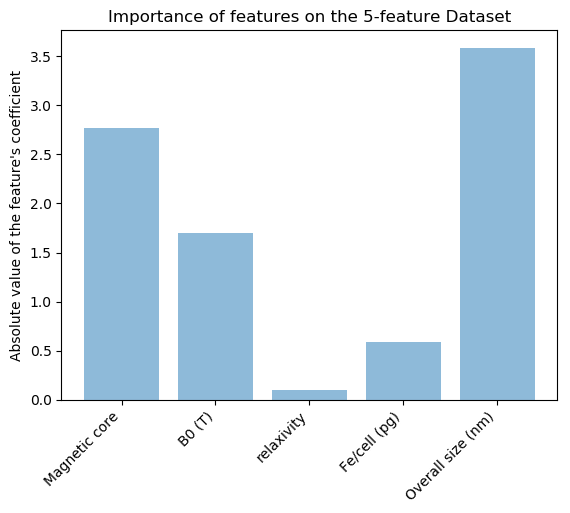

In [23]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

plt.bar(feature_name_for_bar, feature_value_for_bar, align='center', alpha=0.5)
plt.xticks(feature_name_for_bar, feature_name_for_bar)
plt.ylabel("Absolute value of the feature's coefficient")
plt.title('Importance of features on the 5-feature Dataset')
plt.xticks(rotation=45,horizontalalignment='right')

plt.savefig('importance_5.png', bbox_inches="tight")


plt.show()

In [24]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(exported_pipeline, train, train_labels, cv=4)

In [25]:
print('Cross Validation Score: ' ,scores.mean(),'±', scores.std())

Cross Validation Score:  0.8333333333333333 ± 0.16666666666666669
